<a href="https://colab.research.google.com/github/blizanac76/Reinforcement-Learning/blob/main/MonteCarloBlackjack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blackjack D3


Zadatak: Umesto da imamo dilera i igraca, igra se igra kao da postoje 2 obicna igraca, ali tako da prvu rundu igrac 1 ,a drugu rundu posle njega igrac 2. U svakoj igri igraci dobijaju po jednu kartu i imaju jednu zajednicku kartu. Svaki od igraca igra HIT ili HOLD akciju. Ako jedan igrac postane BUSTED ili odigra akciju HOLD, drugi igrac nastavlja da buce karte sve dok i on ne bude BUSTED ili izabere HOLD. Na kraju igrac sa najvecim zbirom <= 21 pobedjuje. Nakon svake partije svaki igrac dobija +1, -1 ili 0 u zavisnosti od toga da li je pobedio, izgubio ili odigrao nereseno.

## Potrebne biblioteke

In [ ]:
from enum import Enum
from dataclasses import dataclass, astuple
from typing import Callable
from random import random, randint
from copy import deepcopy
import matplotlib.patches as mpatches

from tqdm import trange
from rich import print

import numpy as np
import matplotlib.pyplot as plt

## Klasa Card
Svaka karta se sastoji od uredjenog para znak, vrednost tako da nam za ovu klasu treba jos dve klase koje ce biti klasa znaka i klase vrednosti.

### Klasa CardSuit

In [ ]:
class CardSuit(Enum):
    DIAMONDS = 0
    CLUBS = 1
    HEARTS = 2
    SPADES = 3
    def __repr__(self):
        match self:
            case CardSuit.DIAMONDS:
                return "♦"
            case CardSuit.CLUBS:
                return "♣"
            case CardSuit.HEARTS:
                return "♥"
            case CardSuit.SPADES:
                return "♠"

### Klasa CardValue

In [ ]:
class CardValue(Enum):
    ACE = 1
    TWO = 2
    THREE = 3
    FOUR = 4
    FIVE = 5
    SIX = 6
    SEVEN = 7
    EIGHT = 8
    NINE = 9
    TEN = 10
    JACK = 12
    DAME = 13
    KING = 14
    #ACE2 = 11
    def __repr__(self):
        if self == CardValue.ACE:
            return "A"
        elif 2 <= self.value <= 10:
            return str(self.value)
        elif self == CardValue.JACK:
            return "J"
        elif self == CardValue.DAME:
            return "D"
        elif self == CardValue.KING:
            return "K"


### Klasa Card

In [ ]:
@dataclass
class Card:
    value: CardValue
    suit: CardSuit
    def __repr__(self):
        return f"{repr(self.value)}{repr(self.suit)}"

## Klasa CardDeck


In [ ]:
class CardDeck:
    # ugnjezdeni for pravi spil od 52 karte koji se mnozi sa multiplicity. Na kraju formiranja spila se random izmesa.
    def reshuffle(self):
        self.cards = self.multiplicity * [
            Card(value=v, suit=s) for v in iter(CardValue) for s in iter(CardSuit)
        ]
        np.random.shuffle(self.cards)

    def __init__(self, multiplicity=5):
        self.multiplicity = multiplicity
        self.reshuffle()
    # izbacuje poslednju kartu iz spila i spil ostaje bez te karte
    def draw(self):
        if not self.cards:
            self.reshuffle()
        return self.cards.pop(0)

## Klasa State
Stanje se sastoji od sume karata koje igrac ima, informacije da li ima AS-a i sume karata koje diler ima.



In [ ]:
@dataclass
class State:
    total: int
    has_ace: bool
    dealer_total: int

    def __hash__(self):
        return hash(astuple(self))

    def __repr__(self):
        return repr(astuple(self))

AS je specijalna karta koja moze da ima vredonst 1/11 tako da zbog njega imamo slozeniju strukturu funckije update_total(), jer vrednost naseg zbira karata nije jednoznacna.

In [ ]:
def update_total(total: int, has_ace: bool, card_value: CardValue) -> tuple[int, bool]:
    if card_value == CardValue.ACE:
        if total + 11 <= 21:
           # mozemo da zadrzimo AS kao 11 jer je suma manja od 21
            return (total + 11, True)
        else:
            # ne mozemo da zadrzimo AS kao 11 jer je suma veca od 21
            return (total + 1, has_ace)
    else:
        # saturiramo vece karte od 10 na 10
        total += min(card_value.value, 10)
        if total > 21:
            # gledamo da spasemo igraca od BUST-a, a ti ce biti u slucaju da ima AS-a
            if has_ace:
                # racunamo AS-a kao 1 umesto 11 i spasavamo igraca
                total -= 10
                return (total, False)
            else:
                # ne mozemo da ga spasimo
                return (total, has_ace)
        # zbir je manji od 21
        return (total, has_ace)


## Funkcija random_state()
Random stanje je jako bitno za treniranje naseg agenta, jer cemo tako pokriti mnogo vise slucajeva.

In [ ]:
def random_state() -> State:
    # nasumicnu sumu karata generisemo
    total = randint(2, 21)
    if total >= 11:
        r = random()
        if r >= 0.5:
            has_ace = True
        else:
            has_ace = False
    else:
        has_ace = False
    dealer_value = randint(2, 11)
    return State(total, has_ace, dealer_value)

## Funkcija get_init_state()

In [ ]:
def get_init_state(
     #operator | nam sluzi ovde kao operator ili
    state: State | str | None,
    deck: CardDeck,
    common_card: Card | None,
    debug: bool = False,
) -> State:
    # ako nemamo state, napravicemo
    if state is None:
        player_card = deck.draw()
        total, has_ace = update_total(0, False, player_card.value)
        if common_card is None:
            raise ValueError("Common card cannot be None")

        common_card_value = min(common_card.value.value, 10)
        if debug:
            print(f"Player initial hand: {player_card}, {common_card}")
        return State(total, has_ace, common_card_value)
    else:
        #ako je neki string, jer ako zelimo random stanje poslacemo string "random", u durgim slucajevima saljemo None ili State
        if isinstance(state, str):
            assert state == "random", f"Invalid init state specification: '{state}'"
            return random_state()
        #ako je zapravo zadatao stanje neko pri pozivanju funkcije
        else:
            return state


## Funkcija get_init_states()
Pomocu prethodne funkcije inicijalizujemo stanja za oba igraca

In [ ]:
def get_init_states(deck: CardDeck, debug: bool = False) -> (State, State):
    # vuce se zajednicka karta
    common_card = deck.draw()

    # inicijalizujemo stanje za prvog igraca
    player1_state = get_init_state(None, deck, common_card, debug)
    player1_state.total, player1_state.has_ace = update_total(
        player1_state.total, player1_state.has_ace, common_card.value
    )

    # inicijalizujemo stanje za drugog igraca
    player2_state = get_init_state(None, deck, common_card, debug)
    player2_state.total, player2_state.has_ace = update_total(
        player2_state.total, player2_state.has_ace, common_card.value
    )
    return player1_state, player2_state

## Funkcija all_states()
Pravimo listu svih stanja koja ce nam kasnije biti potrebna.

In [ ]:
def all_states() -> list[State]:
    states = []
    for total in range(2, 22):
        for dealer_value in range(2, 12):
        #for dealer_value in range(2,21)
            states.append(State(total, False, dealer_value))
            if total >= 11:
                states.append(State(total, True, dealer_value))
    return states

## Klasa Action()

In [ ]:
class Action(Enum):
    HIT = 0
    HOLD = 1
    def __repr__(self):
        return "HIT" if self == Action.HIT else "HOLD"

## Funkcija random_action()

In [ ]:
def random_action() -> Action:
    r = random()
    if r <= 0.5:
        return Action.HIT
    else:
        return Action.HOLD

## Politika

### Random politika

In [ ]:
def random_policy(s: State) -> Action:
    return random_action()

### Dilerova politika

In [ ]:
def dealer_policy(state: State) -> Action:
    # ako je suma ispod 17 HIT-uje, inace HOLD-uje
    return Action.HIT if state.total < 17 else Action.HOLD

Politiku cemo pozivati u ovoj formi, a callable oznacava da ce na tom mestu biti neka funkcija, tj. u nasem slucaju neka politika.

In [ ]:
Policy = Callable[[State], Action]

## Funkcija get_init_action()


In [ ]:
def get_init_action(
    action: Action | str | None, state: State, policy: Policy
) -> Action:
    if action is not None:
        # ako je neki string
        if isinstance(action, str):
            assert action == "random", f"Ivalid init action specification: '{action}'"
            return random_action()
        #ako je zapravo akcija
        else:
            return action
    # ako je akcija None onda zovemo politiku nad stanjem
    else:
        return policy(state)

TrunLog koirstimo da pamtimo zapazanja, dok je ReportCallback samo prati proces igranja.

In [ ]:
TurnLog = list[tuple[State, Action]]
ReportCallback = Callable[[str], None]

## Funkcija play_turn()
Ovo je jedan potez agenta. Argumenti koje prima funkcija su: politika koju koristi agent, spil karata iz kojeg se vuce karta, inicijalno stanje, inicijalna akcija. Funkcija nam vraca novu sumu agneta ili None ako je BUSTED i zapazanja, tj. sekvencu stanje i akcija tokom igranja.

In [ ]:
def play_turn(
    policy: Policy,
    deck: CardDeck,
    init_state: State | None = None,
    init_action: Action | None = None,
    report_callback: ReportCallback | None = None,
) -> tuple[int | None, TurnLog]:
    # lambda funkcija uslovno poziva report_callback(txt) samo ako report_callback nije None. U durgom slucaju, vraća None, utisavajuci izvrsavanje
    report = lambda txt: report_callback and report_callback(txt)
    state = get_init_state(init_state, deck, None)
    action = get_init_action(init_action, state, policy)
    total, has_ace, dealer_value = astuple(state)
    report(f"[bold]initial state[/] {state}")
    report(
        f"initial total {total} with ACE {has_ace} => [bold]initial action[/] {action}"
    )
    turn_log = [(state, action)]
    while action == Action.HIT:
        card = deck.draw()
        total, has_ace = update_total(total, has_ace, card.value)
        state = State(total, has_ace, dealer_value)
        if total > 21:
            # ako je suma iznad 21 ne zelimo appendujemo informaciju u turning log, dok u drugom slucaju zelimo
            report(
                f"turned finished - [bold]BUSTED![/] card drawn {card} => total {total} with ACE {has_ace}"
            )
            return None, turn_log
        else:
            action = policy(state)
            turn_log.append((state, action))
            report(
                f"card drawn {card} => total {total} with ACE {has_ace} => action chosen {action}"
            )
    report(f"turn finished with final total {total}")
    return total, turn_log

Iskustvo na osnovu koga nas agent uci se moze zapisati ovako:

In [ ]:
Experience = tuple[State, Action, float]

## Funkcija compare_totals()
Ova funkcija samo poredi sume igraca 1 i igraca 2 i na osnovu toga nam salje informaciju ko je pobedio(1/0/-1).

In [ ]:
def compare_totals(player1_total, player2_total) -> int:
    # da li je neko BUST-ovao
    player1_bust = player1_total is None or player1_total > 21
    player2_bust = player2_total is None or player2_total > 21
    # obojica su
    if player1_bust and player2_bust:
        return 0
    # smo prvi
    if player1_bust:
        return -1
    # smo drugi
    if player2_bust:
        return 1
    # ako niko nije
    if player1_total > player2_total:
        return 1
    elif player1_total < player2_total:
        return -1
    else:
        return 0

## Funkcija compute_gain()
Sastoji se iz liste nagrada, i koeficijenta umanjenja koji sve starije nagrade mnozi sa brojem manjim od 1 tako da se izborom njega gleda koliko vrednujemo proslos. Ako je 1 onda svaku nagradu gledamo jednako, a mi to ne zelimo nego zelimo da zaboravaljamo proslost sa nekim rate-om  od *x* procenata.

In [ ]:
def compute_gain(rewards: list[float], gamma: float) -> float:
    g = 0
    w = 1
    for r in rewards:
        g += w * r
        w *= gamma
    return g

## Funkcija build_experience()
Kao argumente prima istoriju poteza igraca, protivnika, rezutltat iz perpektive igraca i koeficijent umanjenja. Funkcija nam vraca iskustvo kao izlaz.


In [ ]:
def build_experience(
    player_log: TurnLog, opponent_log: TurnLog, result: int, gamma: float
) -> Experience:
    player_experience = []
    for i in range(len(player_log)):
        state, action = player_log[i]
        # nagrada je 0 sem za poslednje stanje
        reward = 0 if i < len(player_log) - 1 else result
        next_state, next_action = (
            player_log[i + 1] if i + 1 < len(player_log) else (None, None)
        )
        player_experience.append((state, action, reward, next_state, next_action))

    return player_experience

## Funkcija play_game()
Simuliramo igru sa 2 igraca koja imaju unapred odredjene politike. Posle igre generisemo onakvu listu iskustva za svakog igraca kakva je pogodna za algoritme SARSA-e i Q-learning-a.

In [ ]:
def play_game(
    policy1: Policy,
    policy2: Policy,
    deck: CardDeck,
    gamma: float = 1.0,
    # istorija igranja
    game_report_callback: ReportCallback | None = None,
    #istorija igranja za akcije igraca 1
    player1_report_callback: ReportCallback | None = None,
    #istorija igranja za akcije igraca 2
    player2_report_callback: ReportCallback | None = None,
    debug: bool = False,
    player1_starts: bool = True,
    # rezultat igre, iskustvo za igraca 1 i iskustvo za igraca 2
) -> tuple[int, list, list]:

    report = lambda txt: game_report_callback and game_report_callback(txt)

    player1_state, player2_state = get_init_states(deck, debug)

    if player1_starts:
        # prvo igra igrac 1
        player1_total, player1_log = play_turn(
            policy1, deck, player1_state, report_callback=player1_report_callback
        )
        # drugi igra igrac 2
        player2_total, player2_log = play_turn(
            policy2, deck, player2_state, report_callback=player2_report_callback
        )
    # mozemo da obrnemo ko prvi igra preko parametra player1_starts koji je po defaultu na True
    else:
        player2_total, player2_log = play_turn(
            policy2, deck, player2_state, report_callback=player2_report_callback
        )
        player1_total, player1_log = play_turn(
            policy1, deck, player1_state, report_callback=player1_report_callback
        )

    game_result = compare_totals(player1_total, player2_total)
    report(f"Game result: {game_result}")

    player1_experience = build_experience(player1_log, player2_log, game_result, gamma)
    #negativna vrednost rezlutata igre mora kod igraca 2
    player2_experience = build_experience(
        player2_log, player1_log, -game_result, gamma
    )

    return game_result, player1_experience, player2_experience

## Klasa PolicyTestingResult()

In [ ]:
@dataclass
class PolicyTestingResult:
    games_no: int
    score: int
    wins: float
    draws: float
    losses: float

    def loss_per_game(self):
        return self.score / self.games_no

    def __repr__(self):
        return f"total score={self.score}/{self.games_no} games ({self.loss_per_game():.4f} per game) :: W {self.wins*100:.2f}% | D {self.draws*100:.2f}% | L {self.losses*100:.2f}%"

#Funkcija apply_policy_exhaustive()

In [ ]:
def apply_policy_exhaustive(
    policy1, policy2: Policy, deck: CardDeck, epoch_no=5, gamma=1
) -> tuple[PolicyTestingResult, PolicyTestingResult]:
    wins1, losses1, draws1, score1, games_no1 = 0, 0, 0, 0, 0
    wins2, losses2, draws2, score2, games_no2 = 0, 0, 0, 0, 0

    for epoch in range(epoch_no):
        #igrac 1 pocinje na parne epohe dok igrac 2 na neparne
        player1_starts = (
            epoch % 2 == 0
        )

        res, exp_player1, exp_player2 = play_game(
            policy1, policy2, deck, gamma=gamma, player1_starts=player1_starts
        )
        # za  igraca 1
        games_no1 += 1
        if res == 1:
            wins1 += 1
        elif res == 0:
            draws1 += 1
        else:
            losses1 += 1
        score1 += res
        # za igraca 2, pritom je ovde negativno jer je play_game iz perspektive igraca 1
        games_no2 += 1
        if res == -1:
            wins2 += 1
        elif res == 0:
            draws2 += 1
        else:
            losses2 += 1
        score2 -= res

    result1 = PolicyTestingResult(
        games_no1, score1, wins1 / games_no1, draws1 / games_no1, losses1 / games_no1
    )
    result2 = PolicyTestingResult(
        games_no2, score2, wins2 / games_no2, draws2 / games_no2, losses2 / games_no2
    )

    return result1, result2

In [ ]:
GainsDict = dict[State, tuple[list[float], list[float]]]

Dobijamo recnik Gain-ova gde u recnik za svako stanje u ondosu na akciju appendujemo njegov gain.

In [ ]:
def create_gains_dict(experience: Experience) -> GainsDict:
    #dobijamo gain preko iskustva
    gains_dict = dict()
    for s, a, g in experience:
        action_gains = gains_dict.get(s, ([], []))
        action_gains[a.value].append(g)
        gains_dict[s] = action_gains
    return gains_dict

Apdejtujemo **q vrednosti** pomocu novog targeta. Kao ulazne argumente prima trenutnu procenu, target i alfa koja je brzina ucenja. Dok je izlaz nova apdejtovana procena.

In [ ]:
def update_q_value(current: float, target: float, alpha: float) -> float:
    if current is not None and target is not None:
        return current + alpha * (target - current)
    elif current is None:
        return target
    elif target is None:
        return current
    else:
        return None


QDict = dict[State, tuple[float, float]]

In [ ]:
QDict = dict[State, tuple[float, float]]

Pravi se greedy poliitka na osnovu q vrednosti.

In [ ]:
def create_greedy_policy(q_dict: QDict) -> Policy:
    no_actions = len(list(Action))

    def policy(s: State):
        q_values = q_dict.get(s, None)
        if q_values is not None:
            #ako duzina nije ista baca exception
            assert len(q_values) == no_actions, f"Invalid Q-dict for state {s}."
            #ako je neki q_value None random politika, ako nije onda greedy tj argmax
            if any([q_value is None for q_value in q_values]):
                return random_policy(s)
            else:
                ndx = np.argmax(q_values)
                return Action(ndx)
        else:
            return random_policy(s)
    return policy

## Apdejtovanje Q funkcije

  Sada apdejtujemo Q funckiju iterirajuci kroz iskustvo koje smo prikupili, dok se apdejtovanje konkretno vrsi pomocu SARSA-e ili Q-learning-a.

Formula za SARSA algoritam je:


Q(s, a) = Q(s, a) + alpha * (reward + gamma * Q(s', a') - Q(s, a))

*   Q(s,a) je trenutna vrednost Q funkcije za uredjeni par (s,a)
*   alpha je brzina ucenja, koja nam govori koliko ce jako uticati nova informacija na procenu vrednosti Q funkcije
*   reward je nagrada koje se dobija kada se iz stanja s uradi akcija a
*   gamma je faktor umenjenja koji nam govori koliko su bitne buduce nagrade
*   Q(s', a') je vrednost Q funkcije ako se u sledecem stanju s' primeni akcija a'



Formula za Q-Learning algoritam:
   
Q(s, a) = Q(s, a) + alpha * (reward + gamma * max{ Q(s', a') } - Q(s, a))

*    max{ Q(s', a') } je maksimalna vrednost Q funckije za sledece stanje s' iterirajuci kroz sve moguce akcije a'
*   sve ostalo je isto kao i za SARSU


Funckija update_Q()kao ulaz ima: recnik Q vredsnoti koji je skup vrednosti Q funckije za stanje-akcija , prikupljeno iskustvo,brzinu ucenja, faktor umanjenja i metod koji se koristi za apdejtovanje vrednosti Q funckije.
Izaz je apdejtovane vrednosti Q funckije kada uracunamo celo iskustvo koje imamo.

Treba primeiti da ce izbor izmenju algoritama za apdejtovanje vednosti Q funkcije uticati na to da li cemo koristi konzervativniji pristup uzimajuci u obzir stvarnu sledecu akciju a' preko SARSA-e, ili cemo koristiti Q-learning koji procenjuje buduce nagrade na onsovu maksimalne moguce vrednosti Q funkcije za sledece stanje s'.

In [ ]:
def update_Q(
    q_dict: QDict, experience: Experience, alpha=0.1, gamma=0.9, method="qlearning"
):
    for state, action, reward, next_state, next_action in experience:
        old_value = q_dict.get(state, (0, 0))[action.value]
        #razlikuje se samo dal koristimo max operator
        if next_state is not None:
            if method == "sarsa":
                next_q_value = q_dict.get(next_state, (0, 0))[next_action.value]
                target = reward + gamma * next_q_value
            elif method == "qlearning":
                next_q_values = q_dict.get(next_state, (0, 0))
                target = reward + gamma * max(next_q_values)
        else:
            target = reward
        #preko prethodno napisane funkcije objedinjujemo formule
        new_value = update_q_value(old_value, target, alpha)
        q_values = list(q_dict.get(state, (0, 0)))
        q_values[action.value] = new_value
        q_dict[state] = tuple(q_values)
    return q_dict

##Vizuelizacija politike

Da bi vizualizovali politiku na x osu cemo nalepiti sumu karata od igraca i na y osu sumu karata dilera.

Ako je celija crvena znaci da je akcija HIT, nezavisno od toga da li imamo AS-a kojeg mozemo da menjamo.

Ako je celija plava znaci da je akcija HOLD, nezavisno od toga da li imamo AS-a kojeg mozemo da menjamo.

Ako je celija zelena znaci da je akcija HIT, samo ako imamo AS-a kojeg mozemo da menjamo.

Ako je celija crna znaci da je akcija HIT, ako nemamo AS-a kojeg mozemo da menjamo. Cetvrti slucaj ne izgleda intuitivno pa je zato oznacen crnom bojom da bi se razlikovao od ostalih akcija.

In [ ]:
def visualize_policy(policy):
    player_values = list(range(2, 21))
    dealer_values = list(range(2, 12))
    board = np.ones(shape=(len(dealer_values), len(player_values), 3), dtype=np.uint8)
    for r, dv in enumerate(dealer_values):
        for c, pv in enumerate(player_values):
            if pv < 11:
                action_t = policy(State(pv, False, dv)) == Action.HIT
                if action_t:
                    board[r, c, :] = (255, 0, 0)
                else:
                    board[r, c, :] = (0, 0, 255)
            else:
                action_t = policy(State(pv, True, dv)) == Action.HIT
                action_f = policy(State(pv, False, dv)) == Action.HIT
                if action_t and action_f:
                    board[r, c, :] = (255, 0, 0)
                elif action_t and not action_f:
                    board[r, c, :] = (0, 255, 0)
                elif not action_t and not action_f:
                    board[r, c, :] = (0, 0, 255)
                else:
                    board[r, c, :] = (0, 0, 0)
    plt.imshow(board, extent=[2, 21, 12, 2])
    plt.xticks(np.arange(2.5, 21.5, 1), np.arange(2, 21, 1))
    plt.yticks(np.arange(2.5, 12.5, 1), np.arange(2, 12, 1))
    plt.xlabel("Player total")
    plt.ylabel("Opponent total")

    red_patch = mpatches.Patch(color="red", label="HIT (with or without ACE)")
    blue_patch = mpatches.Patch(color="blue", label="HOLD (with or without ACE)")
    green_patch = mpatches.Patch(color="green", label="HIT only with usable ACE")
    black_patch = mpatches.Patch(color="black", label="HIT only without usable ACE")

    plt.legend(handles=[red_patch, blue_patch, green_patch, black_patch])

    plt.show()

## Treniranje igraca

In [ ]:
def pre_train_players(deck, num_games, alpha=0.1, gamma=0.9, method: str = "qlearning"):
    q_dict_player1 = dict()
    q_dict_player2 = dict()

    for game_no in trange(num_games, desc="Pretraining"):
        player1_starts = game_no % 2 == 0
        #Treniramo igraca 1 protiv dilera
        policy_player1 = create_greedy_policy(q_dict_player1)
        _, exp_player1, _ = play_game(
            policy_player1,
            dealer_policy,
            deck,
            gamma=gamma,
            player1_starts=player1_starts,
        )
        q_dict_player1 = update_Q(
            q_dict_player1, exp_player1, alpha=alpha, method=method
        )

        #Treniramo igraca 2 protiv dilera
        policy_player2 = create_greedy_policy(q_dict_player2)
        _, exp_player2, _ = play_game(
            policy_player2,
            dealer_policy,
            deck,
            gamma=gamma,
            player1_starts=player1_starts,
        )
        q_dict_player2 = update_Q(
            q_dict_player2, exp_player2, alpha=alpha, method=method
        )
    return q_dict_player1, q_dict_player2

##Main()

In [ ]:
def main(
    debug: bool = False,
    pretrain: bool = True,
    method: str = "qlearning",
    epochs: int = 10000,
    epochs_pretrain: int = 50000,
):
    deck = CardDeck()

    if debug:
        #anonimne funkcije
        player1_report_callback = lambda txt: print(f"[bold blue]Player 1:[/] {txt}")
        player2_report_callback = lambda txt: print(f"[bold green]Player 2:[/] {txt}")
        game_report_callback = lambda txt: print(f"[bold red]Game:[/] {txt}")

        policy1 = random_policy
        policy2 = random_policy

        game_result, player1_experience, player2_experience = play_game(
            policy1,
            policy2,
            deck,
            game_report_callback=game_report_callback,
            player1_report_callback=player1_report_callback,
            player2_report_callback=player2_report_callback,
            debug=debug,
        )

        if game_result == 1:
            print("Player 1 wins!")
        elif game_result == -1:
            print("Player 2 wins!")
        else:
            print("The game is a draw.")

        print("Player 1 experience:")
        for experience in player1_experience:
            print(experience)

        print("Player 2 experience:")
        for experience in player2_experience:
            print(experience)

    q_dict_player1 = dict()
    q_dict_player2 = dict()

    q_dict_best_player1 = dict()
    q_dict_best_player2 = dict()

    if pretrain:
        q_dict_player1, q_dict_player2 = pre_train_players(
            deck, num_games=epochs_pretrain, method=method
        )
        pretrained_policy_player1 = create_greedy_policy(q_dict_best_player1)
        pretrained_policy_player2 = create_greedy_policy(q_dict_best_player2)

        print("Visualizing pretrained policy for Player 1:")
        visualize_policy(pretrained_policy_player1)
        print("Visualizing pretrained policy for Player 2:")
        visualize_policy(pretrained_policy_player2)

    res_best_player1 = -float("inf")
    res_best_player2 = -float("inf")

    for epoch in trange(epochs):
        player_1_starts = epoch % 2 == 0
        #kreiramo pohlepne politike za oba igraca
        policy_player1 = create_greedy_policy(q_dict_player1)
        policy_player2 = create_greedy_policy(q_dict_player2)

        #igramo igre i apdejtujemo politike
        _, exp_player1, exp_player2 = play_game(
            policy_player1,
            policy_player2,
            deck,
            gamma=0.9,
            player1_starts=player_1_starts,
        )
        q_dict_player1 = update_Q(q_dict_player1, exp_player1, alpha=0.1, method=method)
        q_dict_player2 = update_Q(q_dict_player2, exp_player2, alpha=0.1, method=method)

        #procenjujemo politike posle svake epohe
        res_player1, res_player2 = apply_policy_exhaustive(
            policy_player1, policy_player2, deck
        )

        #apdejtujemo najbolji rezultat i q vrednosti za svakog od igraca
        if res_player1.score > res_best_player1:
            q_dict_best_player1 = deepcopy(q_dict_player1)
            res_best_player1 = res_player1.score
        if res_player2.score > res_best_player2:
            q_dict_best_player2 = deepcopy(q_dict_player2)
            res_best_player2 = res_player2.score

    # uzimamo najbolju politiku oba igraca
    final_policy_player1 = create_greedy_policy(q_dict_best_player1)
    final_policy_player2 = create_greedy_policy(q_dict_best_player2)

    #racunamo najbolju politiku za oba igraca
    final_res_player1, final_res_player2 = apply_policy_exhaustive(
        final_policy_player1,
        final_policy_player2,
        deck,
        epoch_no=10000,
    )

    # Ispisujemo finalne politike za oba igraca
    print("Final policy evaluation Player 1:")
    print(final_res_player1)
    print("Final policy evaluation Player 2:")
    print(final_res_player2)

    # Vizualzujemo ih
    print("Visualizing final policy for Player 1:")
    visualize_policy(final_policy_player1)
    print("Visualizing final policy for Player 2:")
    visualize_policy(final_policy_player2)

##Pokretanje svega

Pretraining: 100%|██████████| 50000/50000 [00:20<00:00, 2398.99it/s]


Visualizing pretrained policy for Player 1:

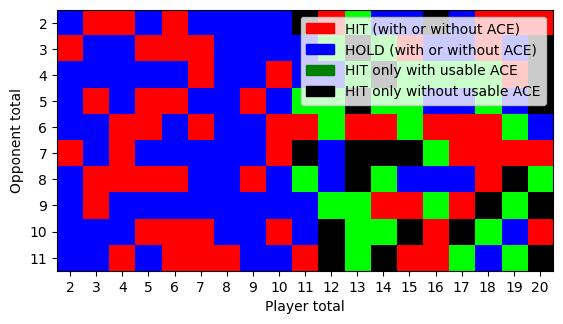

Visualizing pretrained policy for Player 2:

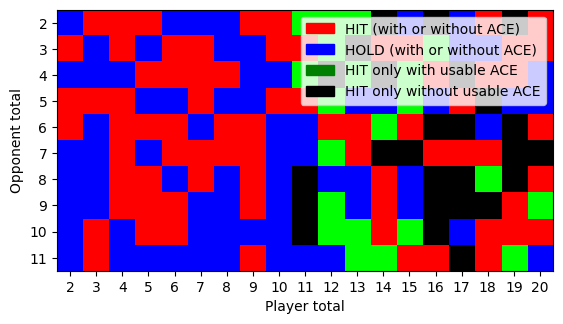

100%|██████████| 10000/10000 [00:12<00:00, 798.32it/s]


Final policy evaluation Player 1:

total score=5/10000 games (0.0005 per game) :: W 38.41% | D 23.23% | L 38.36%

Final policy evaluation Player 2:

total score=-5/10000 games (-0.0005 per game) :: W 38.36% | D 23.23% | L 38.41%

Visualizing final policy for Player 1:

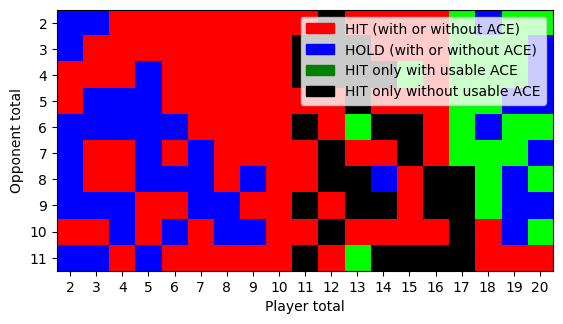

Visualizing final policy for Player 2:

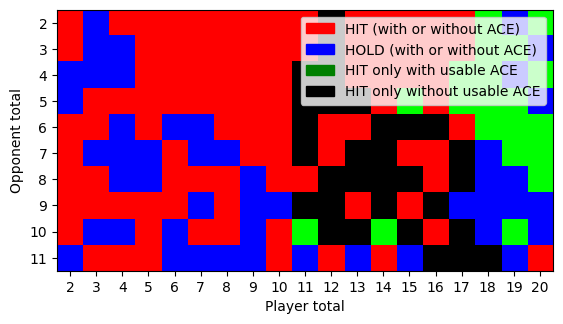

In [ ]:
if __name__ == "__main__":
    main(
        debug=False, pretrain=True, method="qlearning", epochs=10000, epochs_pretrain=50000
    )